# Tutorial 2: Detect anomalous regions with multimodal data

STANDS can simultaneously process H&E images and spatial gene expression data to achieve multimodal anomaly region recognition, i.e., detecting anomalous regions on spatial transcriptomic data. 

This tutorial will guide you through the process step by step. In the demo datasets used here, the reference dataset consists of healthy human breast tissue, while the target dataset consists of human breast cancer tissue, including two types of anomalous regions: cancer in situ and invasive cancer.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import stands
import scanpy as sc
import squidpy as sq
sc.set_figure_params(figsize=(4, 4))

In [3]:
# replace with the path of downloaded demo or another datasets.
input_dir = '/volume3/kxu/data/'
ref_name = 'Breast_full_ref1'
tgt_name = 'Breast_full_tumor1'

ref = sc.read_h5ad(input_dir + ref_name + '.h5ad')
tgt = sc.read_h5ad(input_dir + tgt_name + '.h5ad')
ref_g, tgt_g = stands.read_cross(input_dir, input_dir, ref_name, tgt_name, train_mode=False)
label = [1 if i in ['Cancer in situ', 'Invasive cancer'] else 0 for i in tgt.obs['domain.type']]

In [4]:
ref.obs.sample(n=8)

,domain.type,disease
AGTAACGTTCATCCTG-1,Connective tissue,normal
TGATCTCCGGCGCCAG-1,Connective tissue,normal
CGTAGCGCCGACGTTG-1,Connective tissue,normal
GCTGAATCTTCCAATC-1,Others,normal
GCACAAACGAGGCGTG-1,Breast glands,normal
GCAATTAGTCGCACCG-1,Connective tissue,normal
GATCCTCGACACTGGC-1,Connective tissue,normal
TCGCCGAAGTTGCGTC-1,Breast glands,normal


In [5]:
tgt.obs.sample(n=8)

,domain.type,disease
13x10,Cancer in situ,tumor
3x18,Connective tissue,normal
2x13,Others,normal
9x9,Others,normal
22x9,Connective tissue,normal
12x12,Adipose tissue,normal
26x15,Cancer in situ,tumor
23x16,Connective tissue,normal


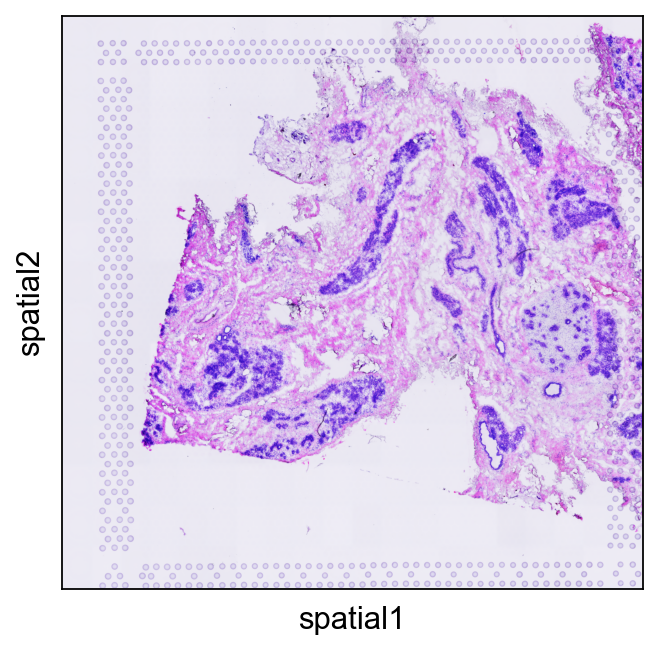

In [6]:
sq.pl.spatial_scatter(ref)

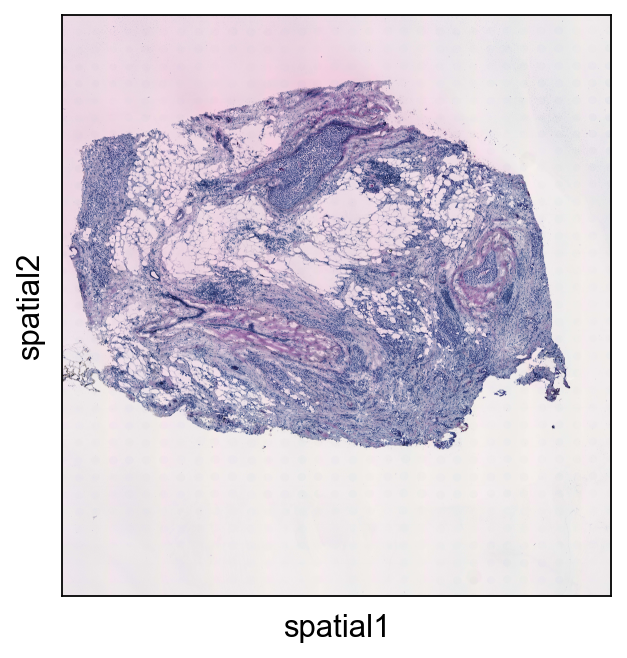

In [7]:
sq.pl.spatial_scatter(tgt)

## Train the model on reference dataset

Because STANDS has been extensively pretrained, here we only need to train for a few epochs on the reference datasets.

In [8]:
model = stands.ADNet(n_epochs = 10)
model.fit(ref_g)

Begin to fine-tune the model on reference datasets...


Train Epochs: 100%|██████████| 10/10 [01:34<00:00,  9.48s/it, D_Loss=-.201, G_Loss=0.495]

Fine-tuning has been finished.


## Detect anoamlous spots on target dataset

STANDS can provide two types of outputs: **anomaly scores**, indicating the probabilities of a spot being an anomalous spot, and **binary classification labels**, where `0` represents a normal spot and `1` represents an anomalous spot. In practice, binary classification labels are determined by the GMM-based thresholder, which utilizes anomaly scores from each sample in the reference and target datasets to infer thresholds and implement binary classification.

In [9]:
# obtain anomaly scores and predicted labels
score, pred = model.predict(tgt_g)

Detect anomalous spots on target dataset...


Inference Epochs:  20%|██        | 20/100 [00:00<00:00, 377.01it/s]

GMM-based thresholder has converged.
Anomalous spots have been detected.



## Evaluate anomaly detection results

STANDS also provides an evaluation function to compute evaluation metrics for the detection performance. Specifically, evaluation can be performed using either anomaly scores or binary classification labels.

In [10]:
stands.evaluate(['AUC', 'Precision', 'Recall', 'F1'], y_true=label, y_score=score)

(0.8797027687296416, 0.86875, 0.86875, 0.86875)

In [11]:
stands.evaluate(['Precision', 'Recall', 'F1'], y_true=label, y_pred=pred)

(0.9072072072072072, 0.8875, 0.897245404)

## Visualizaion

In [12]:
tgt.obs['score'] = score

In [13]:
sc.tl.pca(tgt)
sc.pp.neighbors(tgt)
sc.tl.umap(tgt)

2024-01-10 03:08:49.580647: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


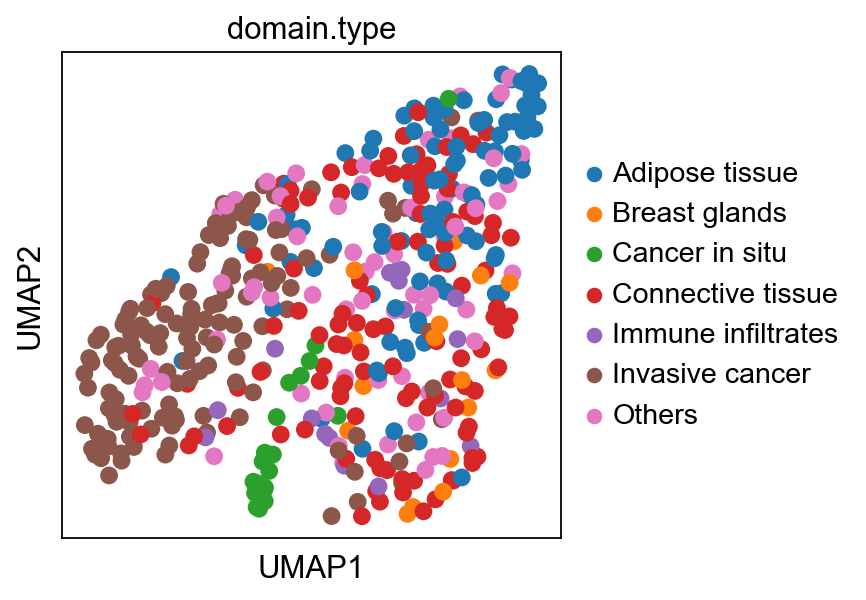

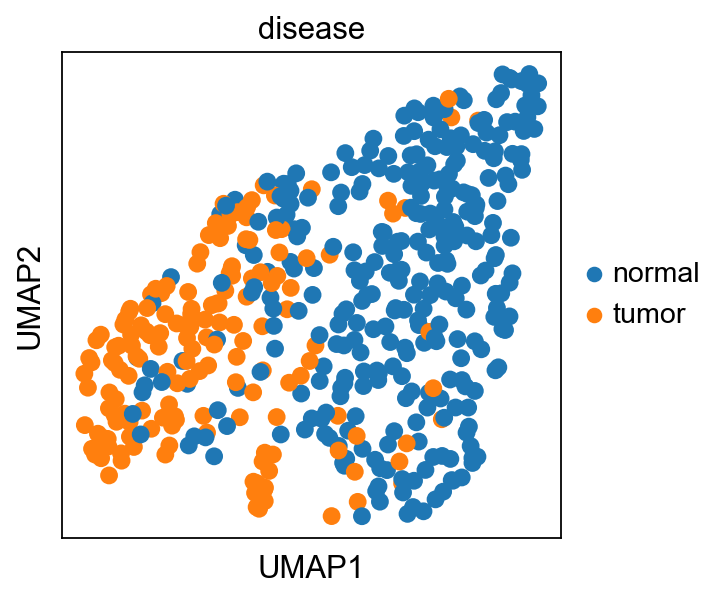

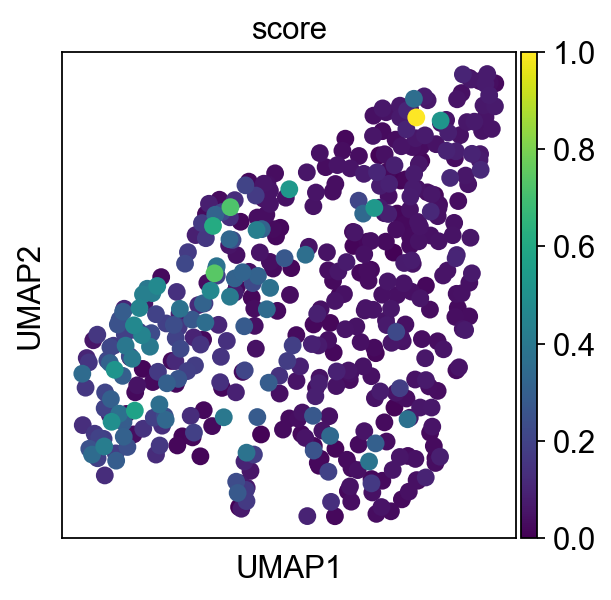

In [14]:
sc.pl.umap(tgt, color=['domain.type'])
sc.pl.umap(tgt, color=['disease'])  # disease labels are also ground truth
sc.pl.umap(tgt, color=['score'])

For further details on the `stands.ADNet`, including various parameters, please refer to the API reference documentation.